In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.4.0-dev (main:87d3fbe, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

In [4]:
import glob

In [5]:
fns = glob.glob("/code/MHC/D*.fasta")

In [6]:
%%time
for fn in fns:
    prefix = fn.split("/")[-1].split("_")[0] 
    sdb = pgrtk.SeqIndexDB()
    sdb.load_from_fastx(fn, w=56, k=56, r=1, min_span=0)
    prefix
    sdb.generate_mapg_gfa(0, f"/results/pgr-out/{prefix}_gen.gfa")
    sdb.write_mapg_idx(f"/results/pgr-out/{prefix}_gen.gidx")

CPU times: user 28.4 s, sys: 9.91 s, total: 38.3 s
Wall time: 2.65 s


In [7]:
all_c2_seqs = []
for fn in fns:
    prefix = fn.split("/")[-1].split("_")[0]
    sdb = pgrtk.SeqIndexDB()
    sdb.load_from_fastx(fn, w=56, k=56, r=1, min_span=0)
    sinfo = sdb.seq_info.copy()
    for sid in sinfo:
        ctg, _, _ = sinfo[sid]
        #print(prefix, ctg)
        seq = sdb.get_seq_by_id(sid)
        all_c2_seqs.append( ((prefix, ctg), seq) )

In [8]:
shmmrspec = {"w": 48, "k":56, "r":9, "min_span":12 }
sdb = pgrtk.SeqIndexDB()
sdb.load_from_fastx("/results/pgr-out/pg_seqs.000.fa",
                    w = shmmrspec["w"], 
                    k = shmmrspec["k"], 
                    r = shmmrspec["r"], 
                    min_span = shmmrspec["min_span"])

In [9]:
matches = []
count = []
for label, seq in all_c2_seqs:
    m = sdb.get_match_positions_with_fragment(seq)
    matches.append((label, m))
    if len(m) > 0:
        count.append(label[0])
        
matches2 = {}
for label, m in matches:
    matches2.setdefault(label[0], [])
    matches2[label[0]].append(m)

In [10]:
def track_simplify(track, threshold=2400, min_size=2000):
    partitions = []
    for x in track:
        if len(partitions) == 0:
            partitions.append([x])
            continue
        if x - partitions[-1][-1] < threshold:
            partitions[-1].append(x)
        else:
            partitions.append([x])
    partitions.sort(key = lambda x: -len(x))
    if len(partitions) > 0:
        rtn = []
        for p in partitions:
            if p[-1] - p[0] > min_size:
                rtn.append(p)
        if len(rtn) > 0:
            return rtn
        else:
            return None
    else:
        return None

In [11]:
gene_track = {}

for sid in sdb.seq_info.copy():
    for label, ms in matches2.items():
        track0_x = set()
        for m in ms:
            if sid in m:
                track0_x.update([_[0] for _ in m[sid]])
                #print(label[0], track0_x[0])
        track0_x = list(track0_x)
        track0_x.sort()
        track0_x = track_simplify(track0_x, threshold=24)
        if track0_x is not None:
            gene_track[(label, sid)] = track0_x

In [12]:
sid_to_gene_match = {}
for label, sid in gene_track:
    tracks = gene_track[(label, sid)]
    for t in tracks:
        #print(label, sid, t[0], t[-1], t[-1]-t[0])
        sid_to_gene_match.setdefault(sid, [])
        sid_to_gene_match[sid].append( ( t[0], t[-1], label, t) )
        

In [13]:
with open("/results/pgr-out/MHC_C2_gene_matches.bed", "w") as f:
    sinfo = sdb.seq_info.copy()
    for sid, ms in sid_to_gene_match.items():
        ms.sort()
        for m in ms:
            print(sinfo[sid][0], *m[:3], sep="\t", file=f)
        

In [14]:
CMAP=[
    "#870098", "#00aaa5", "#3bff00", "#ec0000", "#00a2c3", "#00f400", "#ff1500", "#0092dd",
    "#00dc00", "#ff8100", "#007ddd", "#00c700", "#ffb100", "#0038dd", "#00af00", "#fcd200",
    "#0000d5", "#009a00", "#f1e700", "#0000b1", "#00a55d", "#d4f700", "#4300a2", "#00aa93",
    "#a1ff00", "#dc0000", "#00aaab", "#1dff00", "#f40000", "#009fcb", "#00ef00", "#ff2d00",
    "#008ddd", "#00d700", "#ff9900", "#0078dd", "#00c200", "#ffb900", "#0025dd", "#00aa00",
    "#f9d700", "#0000c9", "#009b13", "#efed00", "#0300aa", "#00a773", "#ccf900", "#63009e",
    "#00aa98", "#84ff00", "#e10000", "#00a7b3", "#00ff00", "#f90000", "#009bd7", "#00ea00",
    "#ff4500", "#0088dd", "#00d200", "#ffa100", "#005ddd", "#00bc00", "#ffc100", "#0013dd",
    "#00a400", "#f7dd00", "#0000c1", "#009f33", "#e8f000", "#1800a7", "#00aa88", "#c4fc00",
    "#78009b", "#00aaa0", "#67ff00", "#e60000", "#00a4bb", "#00fa00", "#fe0000", "#0098dd",
    "#00e200", "#ff5d00", "#0082dd", "#00cc00", "#ffa900", "#004bdd", "#00b400", "#ffc900",
    "#0000dd", "#009f00", "#f4e200", "#0000b9", "#00a248", "#dcf400", "#2d00a4", "#00aa8d",
    "#bcff00",]

In [15]:

bundle_to_id = {}
with open("/results/pgr-out/MHC-C2_pg_seqs.000.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        bundle_id = int(r[5].split(":")[-1])
        bundle_to_id[name] = bundle_id


node_to_bundle_id = {} 
with open("/results/pgr-out/MHC-C2_pg_seqs.000.mapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/MHC-C2_pg_seqs.000.mapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#50CCCCCC"
        stroke_color="#999999A0"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()




## for AMY

In [16]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

In [17]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr1_hg19', 104198140, 104207173
amy_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b, roi_e)

In [18]:
shmmrspec = {"w": 48, "k":56, "r":4, "min_span":12 }
amy_sdb = pgrtk.SeqIndexDB()
amy_sdb.load_from_fastx("/results/pgr-out/pg_seqs.001.fa",
                    w = shmmrspec["w"], 
                    k = shmmrspec["k"], 
                    r = shmmrspec["r"], 
                    min_span = shmmrspec["min_span"])

In [19]:
gene_matches = amy_sdb.get_match_positions_with_fragment(amy_seq)

In [20]:
track=track_simplify(gene_matches)

In [21]:
sinfo = amy_sdb.seq_info.copy()
with open("/results/pgr-out/AMY_gene_track.bed", "w") as f:
    for sid in sinfo:
        if sid not in gene_matches:
            continue
        ctg, _, _ = sinfo[sid]
        tracks = [_[0] for _ in gene_matches[sid]]
        tracks.sort()
        tracks = track_simplify(tracks, threshold=5000, min_size=1000)
        for t in tracks:
            print(ctg, t[0], t[-1], "#000000", sep="\t", file=f)

In [22]:
%%bash
cat << EOF | tr " " "\t" > /wd/results/pgr-out/AMY_example.ord 
hg38_tagged::chr1_hg38_103542919_103798113_0 GRch38_103542919_103798113_0
HG00438.maternal.f1_assembly_v2_genbank::HG00438#2#JAHBCA010000012.1_51600987_51760853_0 HG00438#2#JAHBCA010000012.1_51600987_51760853_0
HG02145.paternal.f1_assembly_v2_genbank::HG02145#1#JAHKSG010000134.1_2168303_2559659_1 HG02145#1#JAHKSG010000134.1_2168303_2559659_1
HG02257.maternal.f1_assembly_v2_genbank::HG02257#2#JAGYVH010000034.1_98278357_98793023_0 HG02257#2#JAGYVH010000034.1_98278357_98793023_0
HG002.paternal.f1_assembly_v2_genbank::HG002#1#JAHKSE010000012.1_16841700_17095738_1 HG002#1#JAHKSE010000012.1_16841700_17095738_1
HG002.maternal.f1_assembly_v2_genbank::HG002#2#JAHKSD010000021.1_102845481_103099468_0 HG002#2#JAHKSD010000021.1_102845481_103099468_0
EOF


In [23]:
%%bash
name=AMY


/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.001.2.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.001.2.hc. \
    --track-range 550000  --track-tick-interval 10000  --track-panel-width 600 --stroke-width 1.2   \
    --annotations /wd/results/pgr-out/${name}_example.ord  \
    --annotation-region-bedfile /results/pgr-out/${name}_gene_track.bed 


/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.001.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.001.hc. \
    --track-range 550000  --track-tick-interval 10000  --track-panel-width 600 --stroke-width 1.2   \
    --annotations /wd/results/pgr-out/${name}_example.ord  \
    --annotation-region-bedfile /results/pgr-out/${name}_gene_track.bed 
    

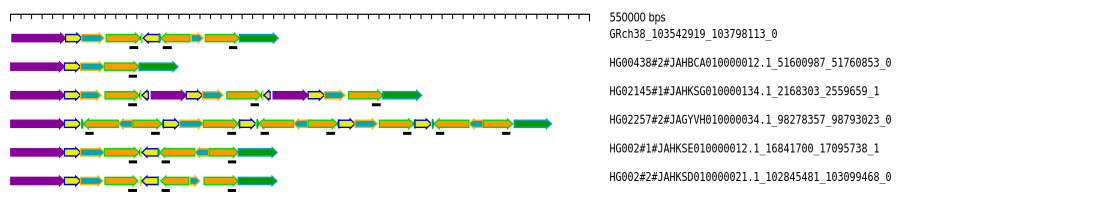

In [24]:
SVG("/wd/results/pgr-out/svg/AMY_pg_seqs.001.2.hc.svg")

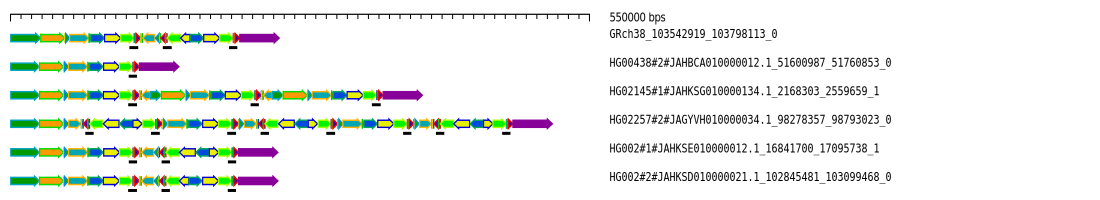

In [25]:
SVG("/wd/results/pgr-out/svg/AMY_pg_seqs.001.hc.svg")

In [26]:

bundle_to_id = {}
with open("/results/pgr-out/AMY_pg_seqs.001.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        bundle_id = int(r[5].split(":")[-1])
        bundle_to_id[name] = bundle_id


node_to_bundle_id = {} 
with open("/results/pgr-out/AMY_pg_seqs.001.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/AMY_pg_seqs.001.pmapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()


node_to_bundle_id = {} 
with open("/results/pgr-out/AMY_pg_seqs.001.mapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/AMY_pg_seqs.001.mapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()

In [27]:

bundle_to_id = {}
with open("/results/pgr-out/AMY_pg_seqs.001.2.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        bundle_id = int(r[5].split(":")[-1])
        bundle_to_id[name] = bundle_id


node_to_bundle_id = {} 
with open("/results/pgr-out/AMY_pg_seqs.001.2.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/AMY_pg_seqs.001.2.pmapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()


node_to_bundle_id = {} 
with open("/results/pgr-out/AMY_pg_seqs.001.2.mapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/AMY_pg_seqs.001.2.mapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()

In [28]:
%%bash
name=AMY
tid="001"

cat /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord2 | awk -F"\t" '{print $1}' | awk -F "." '{print $0"\t"$1"."$2}' > /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3 


/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.001.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.001.hc.3. \
    --track-range 550000  --track-tick-interval 10000  --track-panel-width 1200 --stroke-width 1.2   \
    --annotations /wd/results/pgr-out/${name}_pg_seqs.001.ord3  \
    --annotation-region-bedfile /results/pgr-out/${name}_gene_track.bed \
    --ddg-file /wd/results/pgr-out/AMY_pg_seqs.001.ddg

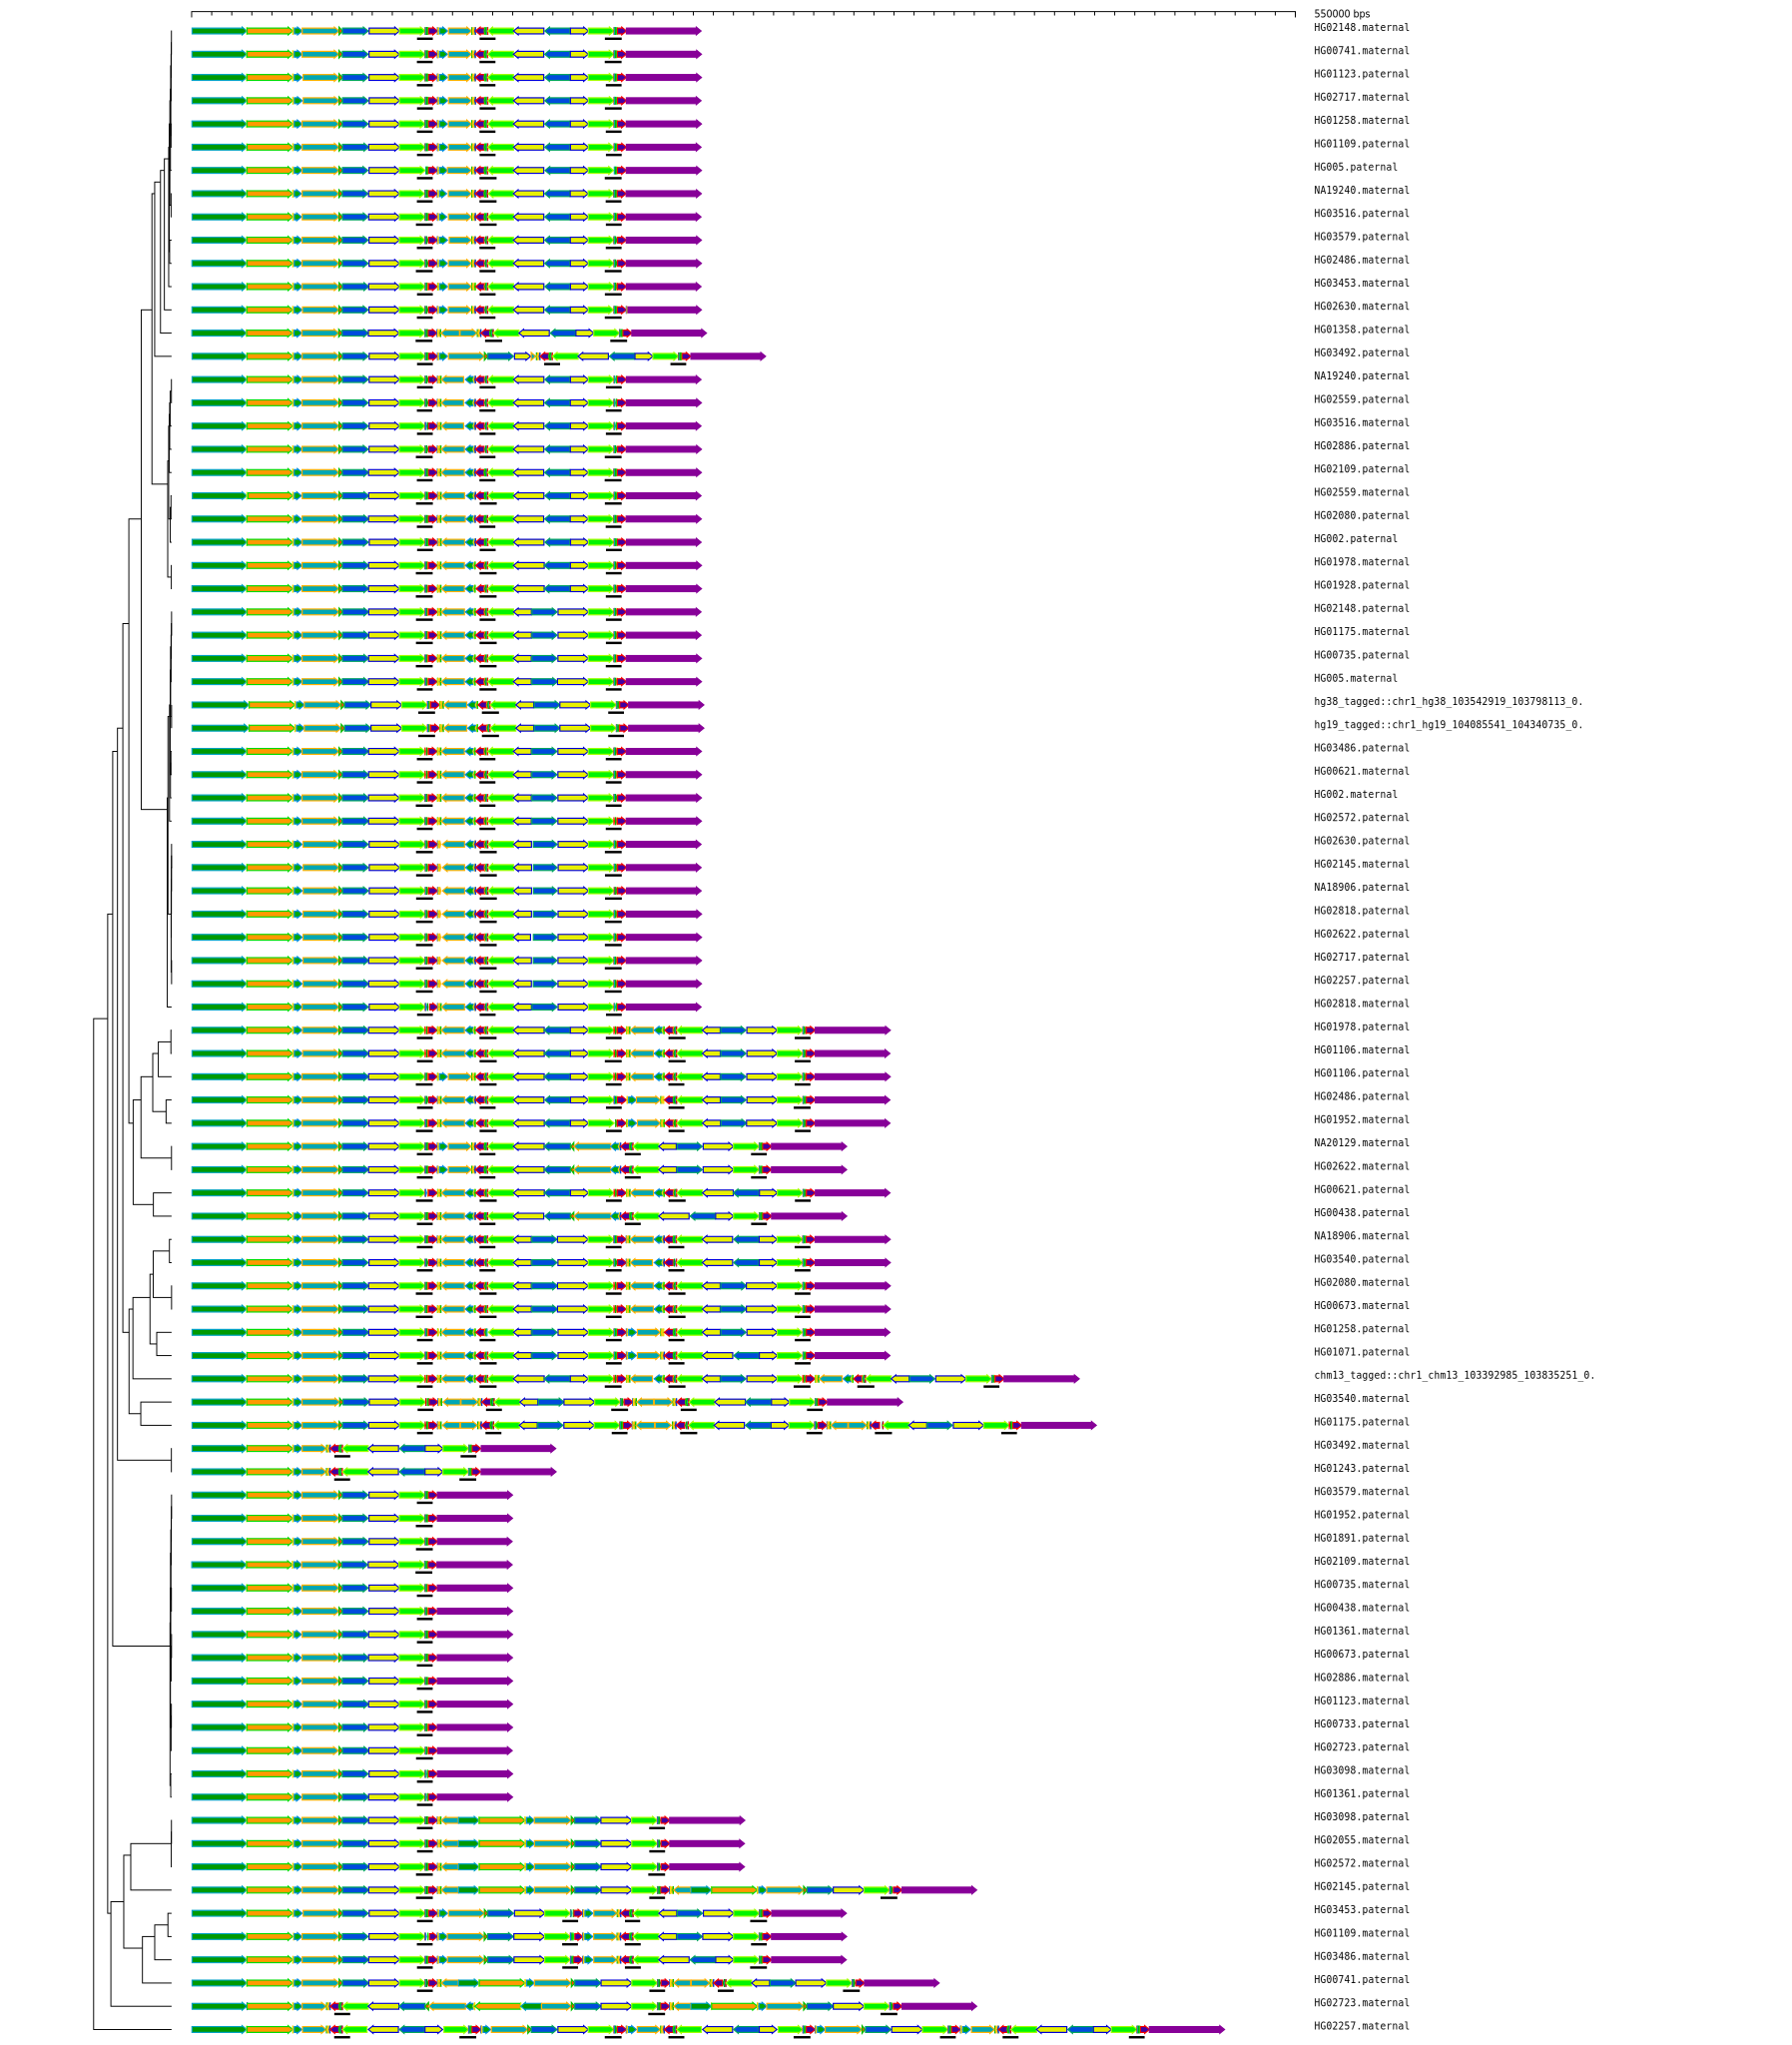

In [29]:
name="AMY"
tid="001"
SVG(f"/wd/results/pgr-out/svg/{name}_pg_seqs.{tid}.hc.3.svg")

# for SMN1/2

In [30]:

bundle_to_id = {}
with open("/results/pgr-out/SMN1-2_pg_seqs.002.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        bundle_id = int(r[5].split(":")[-1])
        bundle_to_id[name] = bundle_id


node_to_bundle_id = {} 
with open("/results/pgr-out/SMN1-2_pg_seqs.002.mapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/SMN1-2_pg_seqs.002.mapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()

node_to_bundle_id = {} 
with open("/results/pgr-out/SMN1-2_pg_seqs.002.pmapg.gfa") as f:
    for r in f:
        r=r.strip().split()
        if r[0] != "S":
            continue
        name = r[4].split(":")[-1]
        node_to_bundle_id[int(r[1])] = bundle_to_id.get(name, None)
        
f = open("/results/pgr-out/SMN1-2_pg_seqs.002.pmapg.color.csv", "w")
print("Name,Color,Bundle_ID", file=f)
for bundle in node_to_bundle_id:
    bundle_id = node_to_bundle_id[bundle]
    if bundle_id is None:
        bundle_color="#60AAAAAA"
        stroke_color="#60AAAAAA"
    else:
        bundle_color = CMAP[((bundle_id * 17) % 97)]
        stroke_color = CMAP[((bundle_id * 47) % 43)]
  
    print(bundle, bundle_color, bundle_id, file=f, sep=",")
f.close()



In [31]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

In [32]:
ref_file_name, SMN1_chr, SMN1_b, SMN1_e = \
('hg38_tagged.fa', 
'chr5_hg38', 
70925087, 70953015)
padding = 100
SMN1_seq = ref_db.get_sub_seq(ref_file_name, SMN1_chr, SMN1_b-padding, SMN1_e+padding)

ref_file_name, SMN2_chr, SMN2_b, SMN2_e = \
('hg38_tagged.fa', 
'chr5_hg38', 
70049669, 70077595)
padding = 100
SMN2_seq = ref_db.get_sub_seq(ref_file_name, SMN2_chr, SMN2_b-padding, SMN2_e+padding)



In [33]:
len(SMN1_seq)

28128

In [34]:
shmmrspec = {"w": 48, "k":56, "r":1, "min_span":0 }
SMN12_sdb = pgrtk.SeqIndexDB()
SMN12_sdb.load_from_fastx("/results/pgr-out/pg_seqs.002.fa",
                    w = shmmrspec["w"], 
                    k = shmmrspec["k"], 
                    r = shmmrspec["r"], 
                    min_span = shmmrspec["min_span"])

In [35]:
gene_matches = SMN12_sdb.get_match_positions_with_fragment(SMN1_seq)

In [36]:
track=track_simplify(gene_matches)

In [37]:
sinfo = SMN12_sdb.seq_info.copy()
with open("/results/pgr-out/SMN1-2_gene_track.bed", "w") as f:
    for sid in sinfo:
        if sid not in gene_matches:
            continue
        ctg, _, _ = sinfo[sid]
        tracks = [_[0] for _ in gene_matches[sid]]
        tracks.sort()
        tracks = track_simplify(tracks, threshold=1000, min_size=0)
        for t in tracks:
            print(ctg, t[0], t[-1], "#000000", sep="\t", file=f)

In [38]:
%%bash
name="SMN1-2"
tid="002"

cat /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord2 | awk -F"\t" '{print $1}' | awk -F "." '{print $0"\t"$1"."$2}' > /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3 

/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.${tid}.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.${tid}.hc. \
    --track-range 2400000  --track-tick-interval 100000 \
    --track-panel-width 1200 --stroke-width 1.4   \
    --annotations /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3  \
    --annotation-region-bedfile /results/pgr-out/${name}_gene_track.bed \
    --ddg-file /wd/results/pgr-out/${name}_pg_seqs.${tid}.ddg


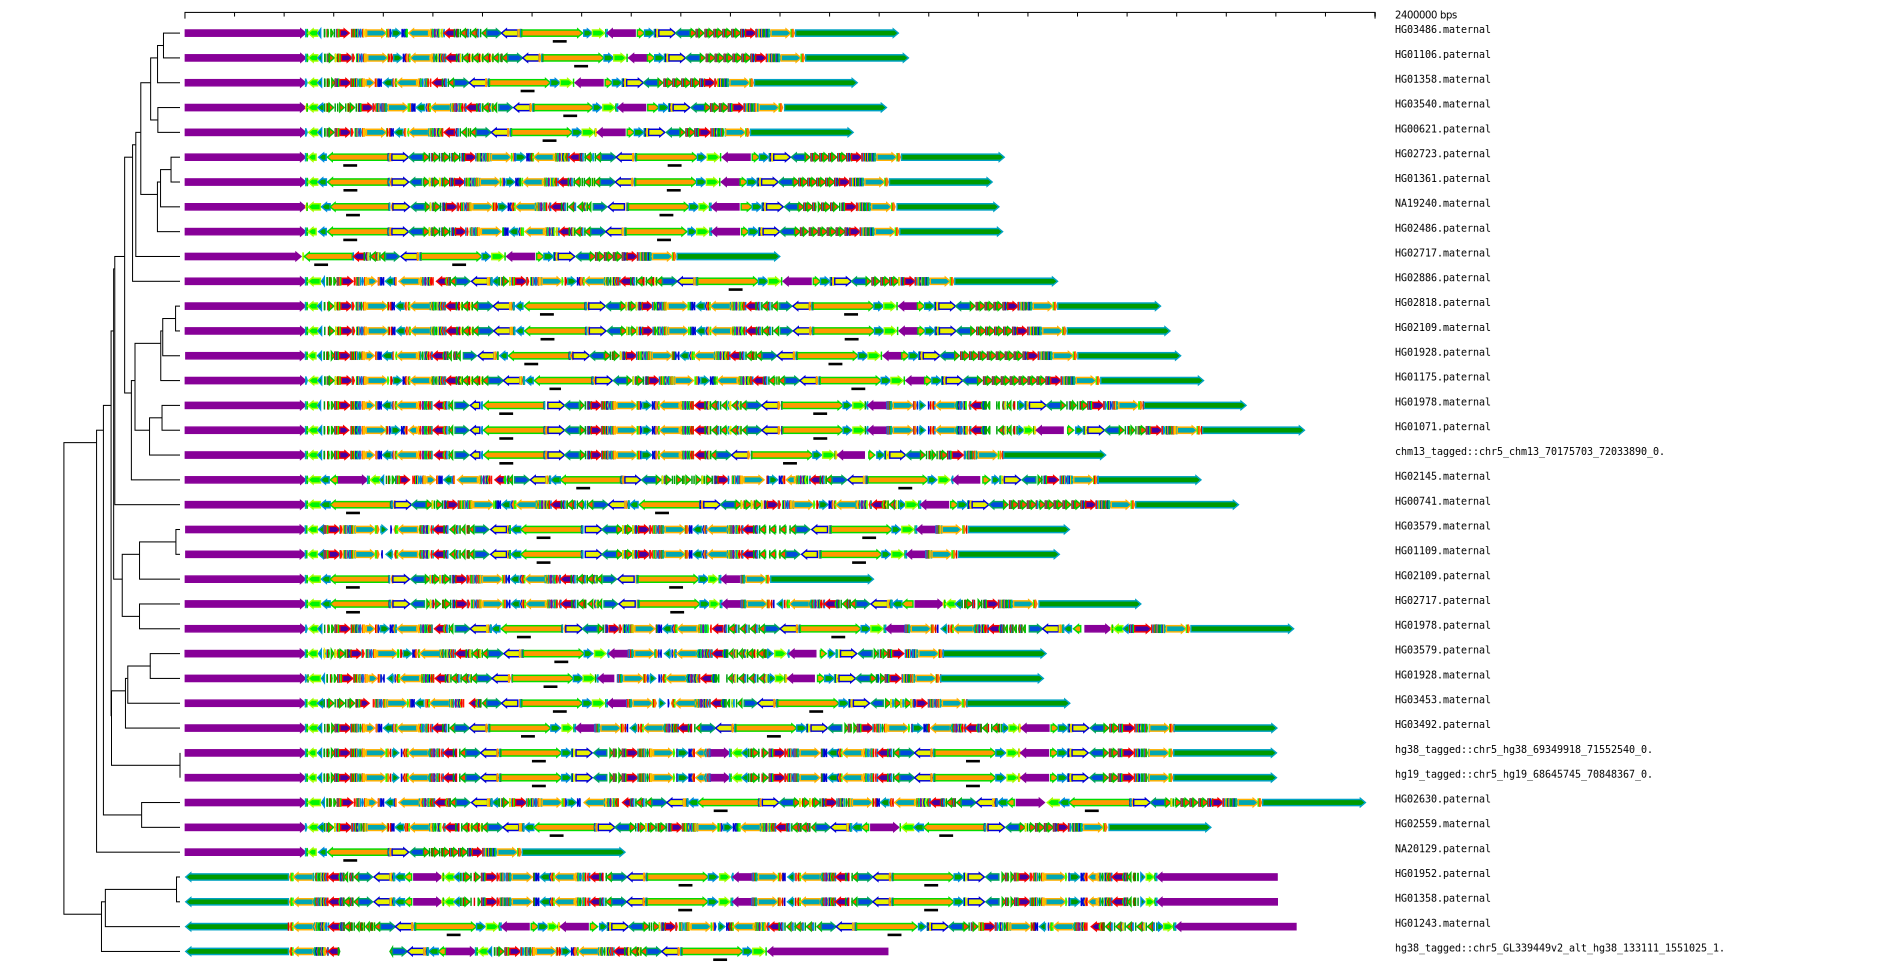

In [39]:
name="SMN1-2"
tid="002"
SVG(f"/wd/results/pgr-out/svg/{name}_pg_seqs.{tid}.hc.svg")

## For LPA

In [40]:
%%bash
name="LPA"
tid="003"

cat /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord2 | awk -F"\t" '{print $1}' | awk -F "." '{print $0"\t"$1"."$2}' > /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3 

/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.${tid}.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.${tid}.hc. \
    --track-range 270000  --track-tick-interval 100000 \
    --track-panel-width 800 --stroke-width 1.4   \
    --annotations /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3  \
    --ddg-file /wd/results/pgr-out/${name}_pg_seqs.${tid}.ddg


In [41]:
name="LPA"
tid="003"
SVG(f"/wd/results/pgr-out/svg/{name}_pg_seqs.{tid}.hc.svg")

# For KATNAL2

In [42]:
%%bash
name="KATNAL2"
tid="004"

cat /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord2 | awk -F"\t" '{print $1}' | awk -F "." '{print $0"\t"$1"."$2}' > /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3 

/wd/code/pgr-pbundle-bed2svg  \
    /wd/results/pgr-out/${name}_pg_seqs.${tid}.bed \
    /wd/results/pgr-out/svg/${name}_pg_seqs.${tid}.hc. \
    --track-range 300000  --track-tick-interval 100000 \
    --track-panel-width 1200 --stroke-width 1.4   \
    --annotations /wd/results/pgr-out/${name}_pg_seqs.${tid}.ord3  \
    --ddg-file /wd/results/pgr-out/${name}_pg_seqs.${tid}.ddg


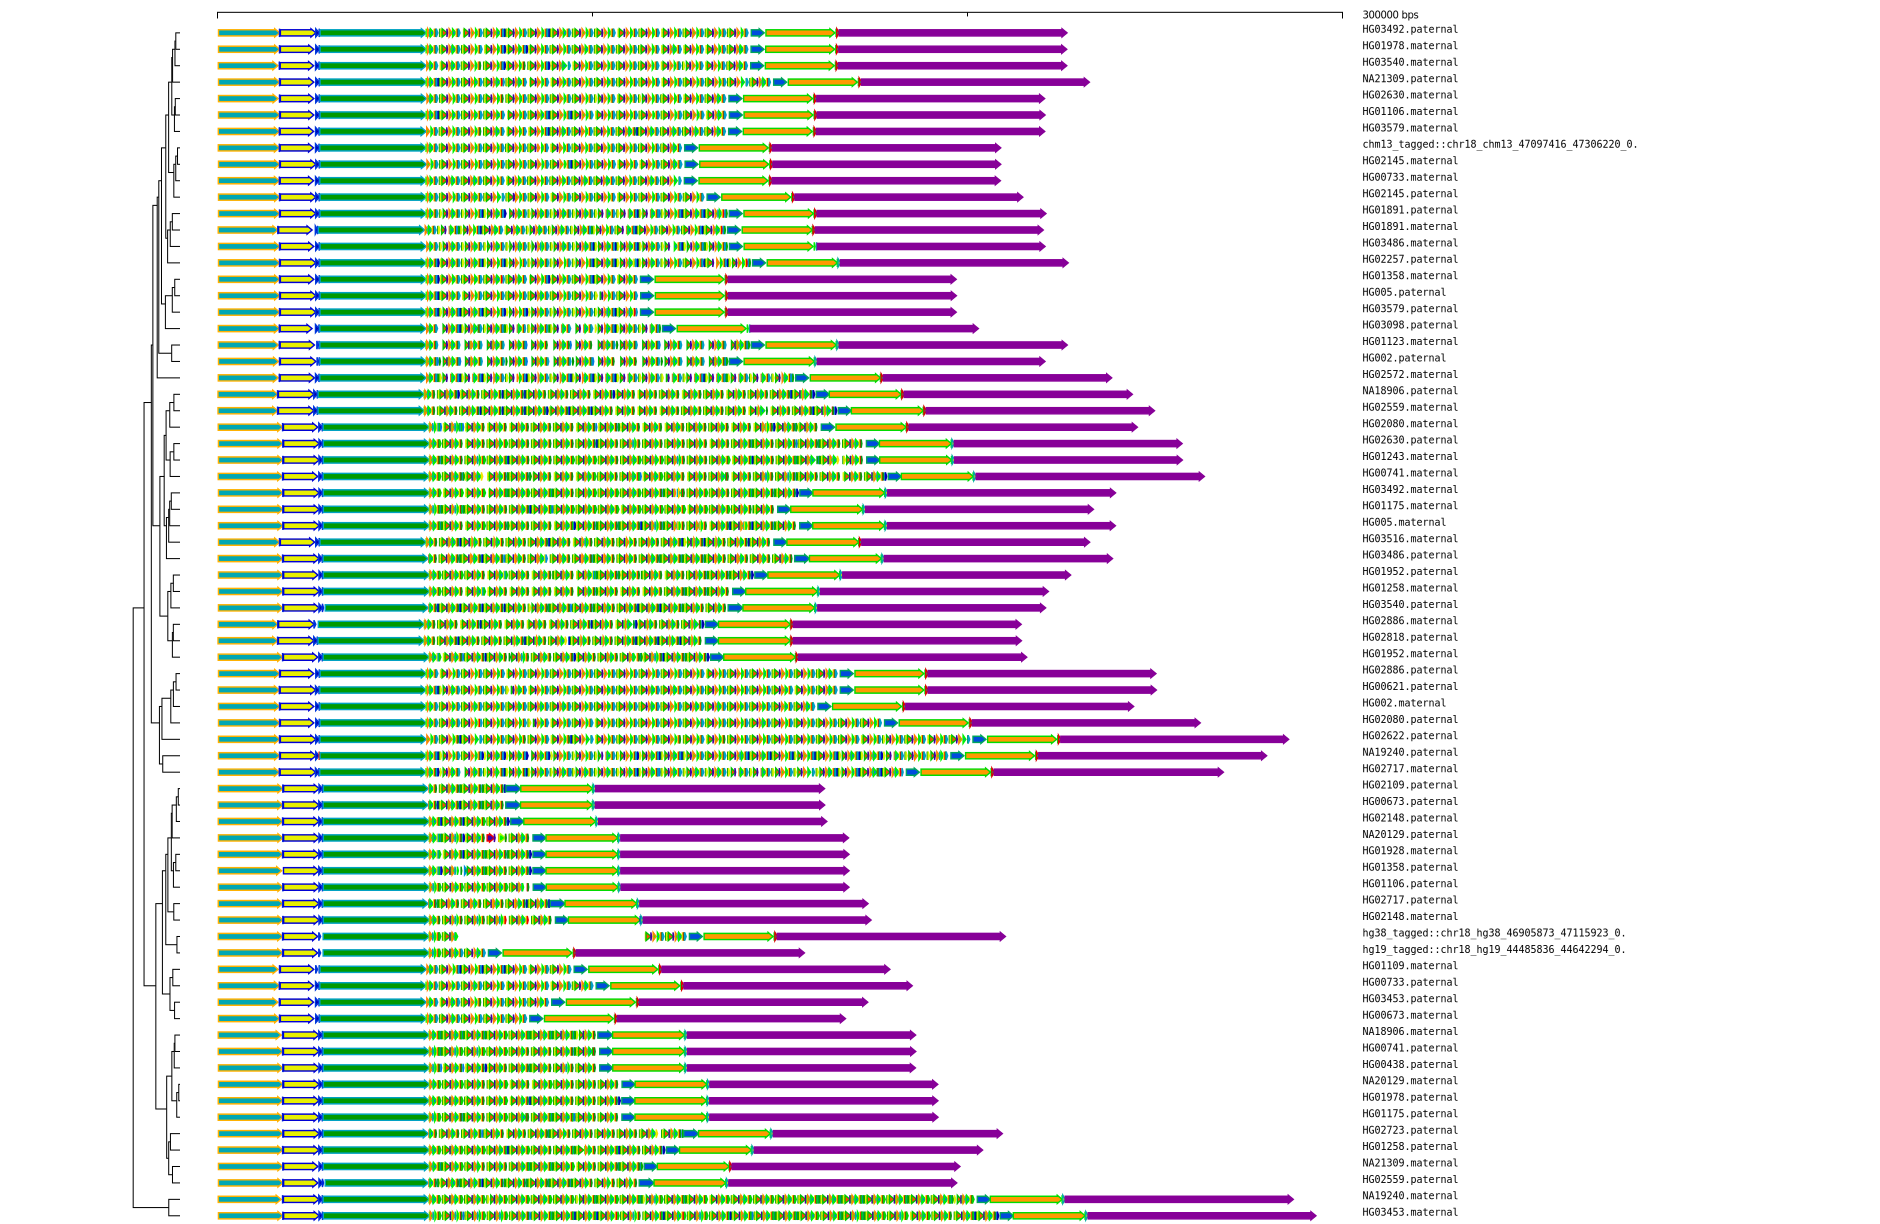

In [43]:
name="KATNAL2"
tid="004"
SVG(f"/wd/results/pgr-out/svg/{name}_pg_seqs.{tid}.hc.svg")